![scai_60mm_logo.png](attachment:scai_60mm_logo.png "SCAI Logo")

# Introduction to Neural Networks based on the Example of Option Pricing
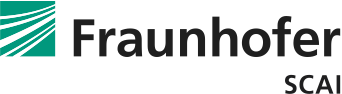

In this notebook, we show how neural networks can be used for the approximation and fast evaluation of classical valuation methods.
In the following, relevant principles are introduced with a focus on the design and training of neural networks in tensorflow (version 2).
Thus, we limit ourselves to the simple case of a call price estimation with the Black-Scholes-Merton model defined as follows:

The price $C$ of a call with maturity $T$, volatility $\sigma$, interest rate $r$ and strike $K$ is given by the equation

$$C=SN(d_1)-Ke^{-rT}N(d_2) $$

with 
$$ d_1 = \frac{1}{\sigma\sqrt{T}} \left( \ln \left( \frac{S}{K} \right) + \left( r + \frac{\sigma^2}{2} \right) T \right) 
\quad \text{and} \quad 
d_1 = \frac{1}{\sigma\sqrt{T}} \left( \ln \left( \frac{S}{K} \right) + \left( r - \frac{\sigma^2}{2} \right) T \right) = d_1 - \sigma\sqrt{T},$$

where $N(d)$ denotes the standard normal cumulative distribution function $$N(d) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^d e^{-z^2/2} dz.$$

In [ ]:
# import statements
import math
import ipywidgets as widgets
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
from tensorflow import Variable, GradientTape
from tensorflow.keras import layers, regularizers, backend, callbacks, optimizers, losses, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

%matplotlib inline

## Helper Functions

In this section, several useful helper functions for plotting and analyzing results are defined. They are not necessary for the overall understanding.

In [ ]:
def plot_loss(history, iter_min = 0, iter_max = -1):
    """Plot loss during network training on training and validation data
    """
    plt.plot(history.history['loss'][iter_min:iter_max],'-x', label='training')
    plt.plot(history.history['val_loss'][iter_min:iter_max],'-x', label='validation')
    plt.legend()
    plt.yscale('log')
    plt.xlabel('#iterations')
    plt.ylabel('loss function value')
    plt.tight_layout()
    
def plot_loss_function(model, x, y, n_samples=30, random_state=42, start=-0.1, end=0.1, stepsize=0.001):
    """Plot projection of the network loss function along straight lines through the current network variables
    This method may be helpful to get an impression if the training has slowed down due 
    to a saddlepoint or maybe because a real local minima has been reached
    """
    np.random.seed(random_state)
    weights = [ np.copy(x) for x in model.get_weights() ]
    
    steps = np.arange(start,end,stepsize)
    loss_values = np.empty(steps.shape)
    for sample in range(n_samples):
        direction = []
        for w in weights:
            direction.append( np.random.uniform(0, 1, size = w.shape) )
        for i in range(steps.shape[0]):
            w = []
            for j in range(len(weights)):
                new_weights = np.copy(weights[j])
                new_weights += steps[i]*direction[j]
                w.append(new_weights)
            model.set_weights(w)
            loss_values[i] = model.evaluate(x,y, verbose=0)
        plt.plot(steps, loss_values)
    model.set_weights(weights)  
    plt.ylabel('loss')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.axvline(x=0.0)
      
def analyze_model_BS(model, history, x, y):
    """This method plots the approximation errors on training and test data set.
    """
    print('Loss function on training data: '+ str(history.history['loss'][-1]))
    print('Loss function on validation data: '+ str(history.history['val_loss'][-1]))

    y_pred = model.predict(x).squeeze()
    
    plt.subplots(figsize=(25,12))
    plt.rcParams.update({'font.size': 18})
    plt.subplot(2,2,1)
    plot_loss(history)
    plt.legend()
    plt.tight_layout()    
    plt.subplot(2,2,2)
    plt.plot(x[:,0], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('K')
    plt.ylabel('y-y_pred')
    plt.tight_layout()
    plt.subplot(2,2,3)
    plt.plot(x[:,1], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('T')
    plt.ylabel('y-y_pred')
    plt.tight_layout()
    plt.subplot(2,2,4)
    plt.plot(x[:,1], y-y_pred, '.', label='y-y_pred')
    plt.xlabel('vol')
    plt.ylabel('y-y_pred')
    plt.tight_layout()

## Data Generation

In this section, we create input data for the training of the neural network, including
- strike
- time to maturity
- volatility
- spot 

We will not consider interest rates or dividends, as they are not necessary under the [Buehler](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1141877 "Volatility and Dividends (2010)") model. The parameters are randomly drawn from a uniform distribution.

In [ ]:
def euro_vanilla_call(S, K, T, r, sigma):
    """ 
    Compute a European call price based on the Black Scholes model
    """
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))  
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

def create_data_example(n_points = 100, noise = False):
    """ 
    Returns:
    a matrix containing the strike, the time to maturity, the volatility, the strike and the call price
    in each column for 'n_points' number of rows
    """
    
    r = 0.0                                      # interest rate (not considered)    
    np.random.seed(42)                           # fix the initial seed to obtain reproducable results
    S = np.random.uniform(0.9,1.1, n_points)     # spot
    K = np.random.uniform(0.6,1.4, n_points)     # strike
    T = np.random.uniform(0.1,3.0, n_points)     # time to maturity
    vol = np.random.uniform(0.05, 1.5, n_points) # volatility
    result = np.empty((n_points, 5))
    for i in range(n_points):
        result[i,0] = K[i]
        result[i,1] = T[i]
        result[i,2] = vol[i]
        result[i,3] = S[i]
        result[i,4] = euro_vanilla_call(S[i],K[i],T[i],r,vol[i]) 
        if noise == True:
            result[i,4] += 0.5*np.random.randn() # add N(0,1)-noise

    return result

### Splitting the Training and Test Set

The data set should be split in a training and a test set, because the quality of the method is not based on the error produced with the data used for training, but it is based on the potential for generalisation of the algorithm, that is, the performance on data not previously seen.
In an extreme case, overfitting can happen, such that the results for the given data are very good, but new data does not achieve an acceptable outcome.
To measure this, a part of the data set should not be used for training the data, but for testing the algorithm after the training procedure.

In [ ]:
size = 5000
data = create_data_example(size)
x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], test_size=0.2, random_state=42)

### Plotting the Data

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(x_train[:,0], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,0], bins=20, alpha=0.5, label='test')
plt.xlabel('strike')
plt.ylabel('#points')

plt.subplot(1,3,2)
plt.hist(x_train[:,1], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,1], bins=20, alpha=0.5, label='test')
plt.xlabel('time to maturity')
plt.ylabel('#points')

plt.subplot(1,3,3)
plt.hist(x_train[:,2], bins=20, alpha=0.5, label='training')
plt.hist(x_test[:,2], bins=20, alpha=0.5, label='test')
plt.xlabel('volatility')
plt.ylabel('#points');

## Creating and Training the Neural Net

In this section, we build and train the neural net by using the *sequential* keras model for a simple multi-layer net in the function *create_simple_network*.
The function includes inner layers with the same activation function which can be specified and an output layer with a linear activation function.
The following image shows such a (6,4,3) network, which means there are three hidden layers with six neurons in the first hidden layer, four neurons in the second hidden layer and three neurons in the third hidden layer.
![nn.png](attachment:nn.png "Neural Network")
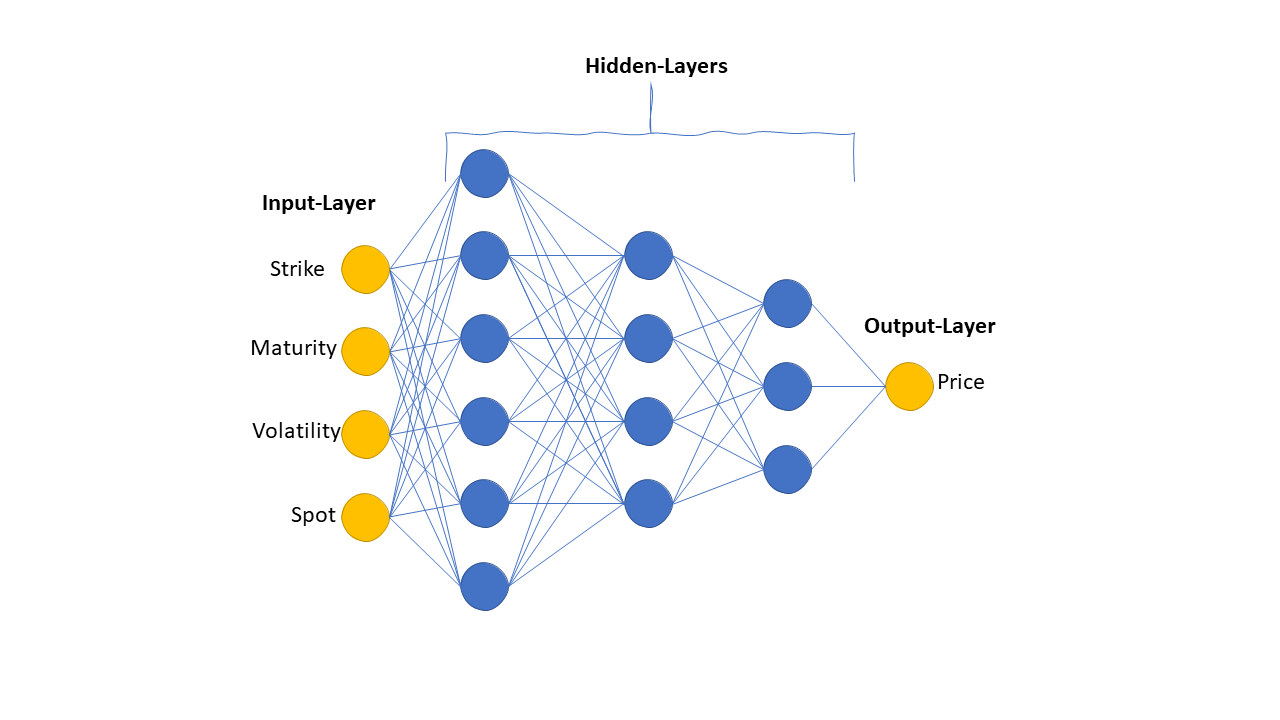

In [ ]:
def create_simple_network(n_neurons, activation='relu',
                           kernel_regularizer=None, bias_regularizer=None, input_dim=1):

    backend.clear_session()
    np.random.seed(42)
    model = Sequential()
    model.add(Dense(n_neurons[0], activation=activation, input_dim=input_dim, 
                    kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)) #input layer
    for n in n_neurons[1:]:
        model.add(Dense(n, activation=activation, kernel_regularizer=kernel_regularizer, 
                    bias_regularizer=bias_regularizer)) 
    model.add(Dense(1, activation='linear')) #output layer
    return model

### Establishing the Model

We now establish the model with two hidden layers
- 20 neurons in the first layer
- 10 neurons in the second layer
and the activation function *elu* for all neurons.

In [ ]:
model = create_simple_network((20,10), 'elu', input_dim=x_train.shape[1])

The model can be examined by calling the *summary* method on the model.

In [ ]:
model.summary()

### Training the Model

In this section, we train the neural net. The performance is significantly dependent on the optimizer, where the following two problems play a decisive role:
- The optimizer finds only a local minimum which does not produce satisfying results for the neural network.
- The optimizer converges very slowly, such that the user may wrongly assume that the minimum is reached without that being the case.

Thus, it is crucial which optimizer and parameters are used.

In [ ]:
# Set a model checkpoint, i.e. during training the validation loss is checked and the model with best loss is saved
cb = []
#cb.append(callbacks.ModelCheckpoint('best_model.h5', save_best_only = True))

# Set callback to log training progress in tensorboard (may be commented out)
#log_dir = 'fit/logs/'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#cb.append(callbacks.TensorBoard(profile_batch=0, log_dir=log_dir, histogram_freq=100))

In [ ]:
# Load a pretrained model to save computation time, may be commented out
#model = keras.models.load_model('best_model.h5')

# Compile the model
model.compile(optimizer=optimizers.Adam(lr=0.0005), loss='MSE')
# Fit the model
tf.random.set_seed(42) 
history = model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0, callbacks=cb,
                    validation_split=0.2)

### Analysis of the Model

#### Training and Approximation Error

We plot the convergence history of the neural net and the point-wise error between the analytical and the approximative solution.

In [ ]:
analyze_model_BS(model, history, x_train, y_train)

Now, we do the same analysis on the test set

In [ ]:
analyze_model_BS(model, history, x_test, y_test)

#### Plotting the Loss Function

<div class="alert alert-block alert-danger">
The execution of the code in this section needs more computation time than the code in other sections.
</div>

To receive an impression of the training of the underlying minimisation problem and assess if the computed minimum is the correct solution, there exists the possibility to plot the cost functional in randomly sampled directions from the current point. One receives one-dimensional cuts of the high dimensional space (in different directions) which can also be plotted.
For the current problem, such plots are depicted in the images down below, while the cutout is reduced from left to right.

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plot_loss_function(model, x_train, y_train, n_samples=40, start = -1.0, end = 1.0, stepsize=0.15)

plt.subplot(1,3,2)
plot_loss_function(model, x_test, y_test, n_samples=40, start = -0.001, end = 0.001, stepsize=0.00015)

plt.subplot(1,3,3)
plot_loss_function(model, x_test, y_test, n_samples=40, start = -0.0001, end = 0.0001, stepsize=0.000015);

#### Changing the learning rate
To get a feeling for the training behavior, the training and subsequent analysis may be conducted for various learning rates (parameter *lr*).

In [ ]:
if False: # for execution change False to True. But be careful: 'the last 42 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f35f421c430> triggered tf.function retracing'. Tracing is expensive: This may significantly increase execution time. ;-)
    lr = [0.1, 0.01, 0.001, 0.0001]
    for l in lr:
        model.compile(optimizer=keras.optimizers.Adam(lr=l), loss='MSE')
        tf.random.set_seed(42)
        history = model.fit(x_train, y_train, epochs=10, batch_size=100, verbose=0, callbacks=cb,
                        validation_split=0.2)
        analyze_model_BS(m, history, x_train, y_train)

### Overfitting Example with a Learning Rate Scheduler

In the following, we show a quick example of an overfitting situation, where the data is fit well on the training data, but not on the validation data. 

In [ ]:
size = 100
data = create_data_example(size, noise=True)
x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], test_size=0.2, random_state=42)
overfit_model = create_simple_network((30,30,30), 'elu', input_dim=x_train.shape[1])
overfit_model.compile(optimizer=optimizers.Adam(lr=0.0005), loss=losses.MSE)

history = overfit_model.fit(x_train, y_train, epochs=12000, batch_size=20, verbose=0, validation_split=0.2)
analyze_model_BS(overfit_model, history, x_train, y_train)
#analyze_model_BS(model, history, x_test, y_test)

#### Learning Rate Scheduler

<div class="alert alert-block alert-danger">
The execution of the code in this section needs more computation time than the code in other sections due to the number of epochs.
</div>

As the loss function value begins to oscillate with an increasing number of iterations, a learning rate scheduler can be introduced to reduce the learning rate over time in order to improve on convergence.

In [ ]:
def learning_rate_scheduler(choose_schedule: str):
    
    if choose_schedule == 'learning_rate_time_decay'  :
        def learning_rate_time_decay(epoch, lr): 
            return lr * 1 / (1 + decay * epoch)
        learning_rate_scheduler = callbacks.LearningRateScheduler(learning_rate_time_decay)

    elif choose_schedule == 'learning_rate_step_decay':
        drop_rate = 0.5
        epochs_drop = 100
        def learning_rate_step_decay(epoch, lr):
            return lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))
        learning_rate_scheduler = callbacks.LearningRateScheduler(learning_rate_step_decay)

    elif choose_schedule == 'learning_rate_exp_decay':
        k = 0.1
        def learning_rate_exp_decay(epoch, lr):
            if epoch > 0 and epoch%100==0: return lr * math.exp(-k*epoch)
            else: return lr
        learning_rate_scheduler = callbacks.LearningRateScheduler(learning_rate_exp_decay)

    else:
        print('Learning rate scheduler unknown! None chosen.')
        learning_rate_scheduler = []
    
    return learning_rate_scheduler

In [ ]:
initial_learning_rate = 0.0005
num_of_epochs = 60000
decay = initial_learning_rate / num_of_epochs 
choose_schedule = 'learning_rate_time_decay'

size = 100
data = create_data_example(size, noise=True)
x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], test_size=0.2, random_state=42)
overfit_model = create_simple_network((30,30,30), 'elu', input_dim=x_train.shape[1])
overfit_model.compile(optimizer=optimizers.Adam(lr=initial_learning_rate), loss=losses.MSE)

history_decay = overfit_model.fit(x_train, y_train, epochs=num_of_epochs, batch_size=20, 
                                             verbose=0, validation_split=0.2, 
                                             callbacks=[learning_rate_scheduler(choose_schedule)])

analyze_model_BS(overfit_model, history_decay, x_train, y_train)

## Greeks - Algorithmic Differentiation (AD)

Most frameworks for machine learning offer the opportunity to differentiate the model with respect to specific model parameters by automatic differentiation (**AD** or **AAD**).
This is based on the fact that for the training of the neural net with a stochastic gradient method, the appropriate derivatives of the cost functional with respect to the parameters of neural nets are needed.

This can be used to calculate the derivatives of the input parameters (in finance often called **Greeks**).
Tensorflow offers a simple possibility with *GradientTapes*, which we use to calculate the derivative of the option price with respect to the spot (**Delta**) and the volatility (**Vega**).

In [ ]:
# This function calculates the prices and derivatives with respect to the input parameters 
# for the given model with automatic differentiation

def compute_price_delta(x, model):
    x_ = Variable(x)
    with GradientTape() as g:
        g.watch(x_)
        y = model(x_, training=False)
    return y, g.gradient(y, x_)

### Error Analysis

We compare the price as well as the delta and vega of the Black-Scholes-Merton model with the results of the neural nets. Note that the neural network resulting from the above training using the default parameters performs poorly. Play around (especially with number of epochs and the learning rate) to enhance the results.

In [ ]:
def plot_errors(K, vol, T):
    S = np.linspace(0.8, 1.2, 50)
    x = np.empty((S.shape[0],4))
    x[:,0] = K
    x[:,1] = T
    x[:,2] = vol
    x[:,3] = S
    price, deriv = compute_price_delta(x, model)
    
    fig = plt.figure(figsize=(18,6))
    price_bs = [euro_vanilla_call(S[i], K, T, 0.0, vol) for i in range(S.shape[0])]
    plt.subplot(1,3,1)
    plt.plot(S, price,'-x', label='NN')
    plt.plot(S, price_bs,'-x', label='Black-Scholes')
    plt.xlabel('spot')
    plt.ylabel('price')
    plt.legend()
    plt.tight_layout()
    
    delta_bs = [(euro_vanilla_call(S[i]+0.001, K, T, 0.0, vol)-price_bs[i])/0.001 for i in range(S.shape[0])]
    plt.subplot(1,3,2)
    plt.plot(S, deriv[:,3],'-x', label='NN')
    plt.plot(S, delta_bs,'-x', label='Black-Scholes')
    plt.xlabel('spot')
    plt.ylabel('delta')
    plt.legend()
    plt.tight_layout()
    
    vega_bs = [(euro_vanilla_call(S[i], K, T, 0.0, vol+0.001)-price_bs[i])/0.001 for i in range(S.shape[0])]
    plt.subplot(1,3,3)
    plt.plot(S, deriv[:,2],'-x', label='NN')
    plt.plot(S, vega_bs,'-x', label='Black-Scholes')
    plt.xlabel('spot')
    plt.ylabel('vega')
    plt.legend()
    plt.tight_layout()

In [ ]:
widgets.interact(plot_errors, 
                 K=widgets.FloatSlider(value=1.0, min=0.6,max=1.4, step=0.02, continuous_update=False), 
                 vol=widgets.FloatSlider(value=0.2, min=0.05, max=0.8, step=0.01, continuous_update=False), 
                 T=widgets.FloatSlider(value=1.0, min=10.0/365.0, max=3.0, step=30.0/365.0, continuous_update=False));